We start by reading in the ratings and unique movies dataframes. 

In [128]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab as pl
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
import random
from math import sqrt
names = ['index_id', 'item_id', 'pmovie_id','user_id','rating']

df = pd.read_csv('./ratingsnew.csv', sep=',', names=names)
#df=df.groupby('item_id').filter(lambda x: len(x) >= 10)
df=df.sort(['item_id'],ascending=False)
random.seed(22)
df1 = pd.read_csv('./moviesnew.csv', sep=',')
#df.shape

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Next we create a user item matrix with users on the rows, movies as columns and individual ratings as elements.  

In [74]:
n_users = df.user_id.unique().shape[0]
n_items = df1.id.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[4]-1, row[2]-1] = row[5]

We write a custom function to split the user-item matrix randomly into train and test. 

In [75]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [76]:
train_data, test_data = train_test_split(ratings)
train_datai = train_data.T #transpose for collaborative filtering
test_datai = test_data.T #transpose for collaborative filtering


(9125, 671)

In [77]:
from sklearn.neighbors import NearestNeighbors
newindices = {}
nbrs = NearestNeighbors(n_neighbors=100, algorithm='brute',metric='cosine').fit(train_data)
distances, indices = nbrs.kneighbors(train_data)

for i in xrange(train_data.shape[0]):
    a=np.delete(indices[i], 0, 0)
    newindices[i] = a

In [78]:
newindices1 = {}
nbrs = NearestNeighbors(n_neighbors=100, algorithm='brute',metric='cosine').fit(train_datai)
distances, indices = nbrs.kneighbors(train_datai)

for i in xrange(train_datai.shape[0]):
    a=np.delete(indices[i], 0, 0)
    newindices1[i] = a
#newindices1[519]

In [79]:
def findneighboursuser(label,flag='user'):
    neighbours = {}
    
    for i in label.keys():
        for j in xrange(label[i].shape[0]):
            
            if flag == 'user':
                
        #print label[i][j]
                neighbours[label[i][j]] = np.intersect1d(newindices[label[i][j]], label[i])
            else:
                neighbours[label[i][j]] = np.intersect1d(newindices1[label[i][j]], label[i])
    return neighbours

In [80]:

user_distance = pairwise_distances(train_data, metric='cosine')
item_distance = pairwise_distances(train_datai, metric='cosine')
user_similarity2 = np.exp(- user_distance ** 2 / (2. * 0.1 ** 2))
user_similarity1 = 1 - user_distance
item_similarity1 = 1 - item_distance
item_similarity2 = np.exp(- item_distance ** 2 / (2. * 0.1 ** 2))

In [81]:
import kmedoids

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, DBSCAN,AgglomerativeClustering, DBSCAN
i =4
def makeclusters(ratings,similarity,distance,flag,n_cluster,flag1='user'):
    neighbors = {}
    if flag == 'k-means':
        
        pca = PCA().fit(ratings).transform(ratings)
        movieCluster1 = KMeans(n_clusters=n_cluster, n_init=5,random_state=1).fit(pca)
        clusterlabelist = movieCluster1.labels_
        label = getclusterlabels(ratings,clusterlabelist,n_cluster)
        neighbors = findneighboursuser(label,flag1)
    if flag == 'k-mediods':
        M, label = kmedoids.kMedoids(distance,n_cluster)
        neighbors = findneighboursuser(label,flag1)
        clusterlabelist = np.zeros((ratings).shape[0])
        for k in label:
            for q in xrange(label[k].shape[0]):
                clusterlabelist[label[k][q]] = k
    if flag == 'spectral':
        clusterlabelist = SpectralClustering(n_cluster).fit_predict(similarity)
        label = getclusterlabels(ratings,clusterlabelist,n_cluster)
        neighbors = findneighboursuser(label,flag1)
    return clusterlabelist,neighbors



In [82]:
def getclusterlabels(ratings,labellist,k):
    label = {}

    traindf = pd.DataFrame(ratings)
    traindf['label'] =labellist
    for j in range(0,k):
        label[j] = np.array(traindf[traindf['label'] == j].index)
    return label

In [83]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.nanmean(((pred - actual) ** 2))

In [84]:
def predict_nobias(ratings, similarity):
    user_bias = ratings.mean(axis=1)
    ratings = (ratings - user_bias[:, np.newaxis]).copy()
    pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    pred += user_bias[:, np.newaxis]

        
    return pred

In [85]:
def predict_topk_nobias(ratings, similarity,clusterlabel, kind='user'):
    pred = np.zeros(ratings.shape)
    
    user_bias = ratings.mean(axis=1)
    ratings = (ratings - user_bias[:, np.newaxis]).copy()
    for i in clusterlabel.keys():
        top_k_users = np.array(clusterlabel[i])
        if top_k_users.size == 0:
            top_k_users = [np.argsort(similarity[:,i])[:-40-1:-1]]
            #for i in top_k_users:
        for j in xrange(ratings.shape[1]):
            pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
            pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    pred += user_bias[:, np.newaxis]
   

    return pred

In [86]:
userpred = predict_nobias(ratings=train_data,similarity=user_similarity1)
itempred = predict_nobias(ratings=train_datai,similarity=item_similarity1)
user_test = sqrt(get_mse(userpred, test_data))
user_train = sqrt(get_mse(userpred, train_data))


In [87]:
k_array = [2,4,6,8]
kmediodsuser_test = []
kmediodsuser_train = []
from math import sqrt
for k in k_array:
    clusterlabelist,clusterlabel=makeclusters(train_data,user_similarity1,user_distance,'k-mediods',k)
    #labels = list(clusterlabel.keys())
    pred = predict_topk_nobias(train_data, user_similarity1, clusterlabel)
    kmediodsuser_test += [sqrt(get_mse(pred, test_data))]
    kmediodsuser_train += [sqrt(get_mse(pred, train_data))]

In [88]:
k_array = [2,4,6,8]
kmeansuser_test = []
kmeansuser_train = []
for k in k_array:
    clusterlabelist,clusterlabel=makeclusters(train_data,user_similarity1,user_distance,'k-means',k)
    pred = predict_topk_nobias(train_data, user_similarity1, clusterlabel)
    kmeansuser_test += [sqrt(get_mse(pred, test_data))]
    kmeansuser_train += [sqrt(get_mse(pred, train_data))]

In [89]:
k_array = [2,4,6,8]
spectraluser_test = []
spectraluser_train = []
for k in k_array:
    clusterlabelist,clusterlabel=makeclusters(train_data,user_similarity1,user_distance,'spectral',k)
    pred = predict_topk_nobias(train_data, user_similarity1, clusterlabel)
    spectraluser_test += [sqrt(get_mse(pred, test_data))]
    spectraluser_train += [sqrt(get_mse(pred, train_data))]

In [90]:
k_array = [2,4,6,8]
kmediodsitem_test = []
kmediodsitem_train = []
from math import sqrt

for k in k_array:
    clusterlabelist,clusterlabel=makeclusters(train_datai,item_similarity1,item_distance,'k-mediods',k,'item')
    pred = predict_topk_nobias(train_datai, item_similarity1, clusterlabel)
    kmediodsitem_test += [sqrt(get_mse(pred, test_datai))]
    kmediodsitem_train += [sqrt(get_mse(pred, train_datai))]

In [91]:
k_array = [2,4,6,8]
kmeansitem_test = []
kmeansitem_train = []
from math import sqrt

for k in k_array:
    clusterlabelist,clusterlabel=makeclusters(train_datai,item_similarity1,item_distance,'k-means',k,'item')
    pred = predict_topk_nobias(train_datai, item_similarity1, clusterlabel,kind='item')
    kmeansitem_test += [sqrt(get_mse(pred, test_datai))]
    kmeansitem_train += [sqrt(get_mse(pred, train_datai))]

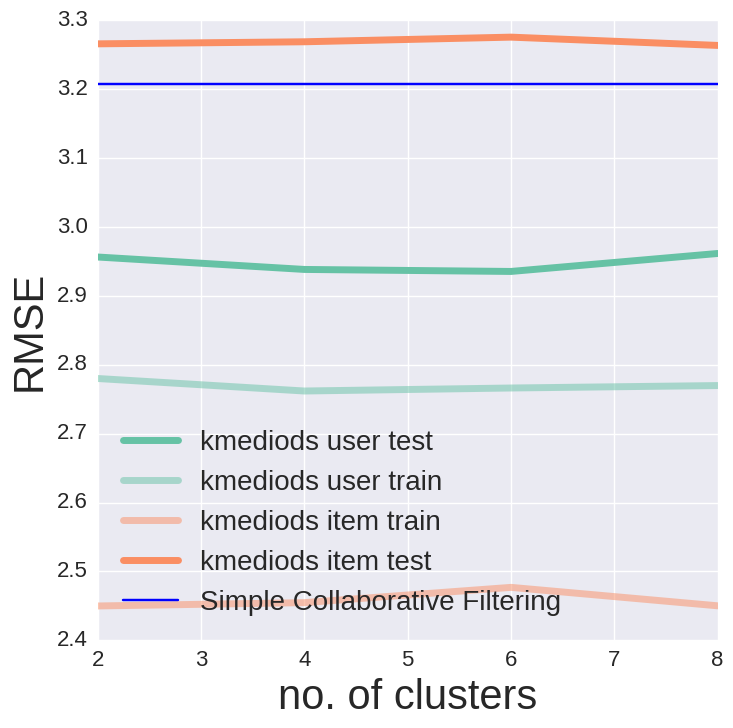

In [92]:
%matplotlib inline
sns.set()
pal = sns.color_palette("Set2", 4)
plt.figure(figsize=(8, 8))
plt.plot(k_array, kmediodsuser_test, c=pal[0], label='kmediods user test', linewidth=5)
plt.plot(k_array, kmediodsuser_train, c=pal[0], alpha=0.5, label='kmediods user train', linewidth=5)
plt.plot(k_array, kmediodsitem_train, c=pal[1],  alpha=0.5, label='kmediods item train', linewidth=5)
plt.plot(k_array, kmediodsitem_test, c=pal[1], label='kmediods item test', linewidth=5)
plt.axhline(y=user_test,label = 'Simple Collaborative Filtering')
#plt.plot(user_test, c=pal[1], label='user test', linewidth=5)


#plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
#plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('no. of clusters', fontsize=30);
plt.ylabel('RMSE', fontsize=30);

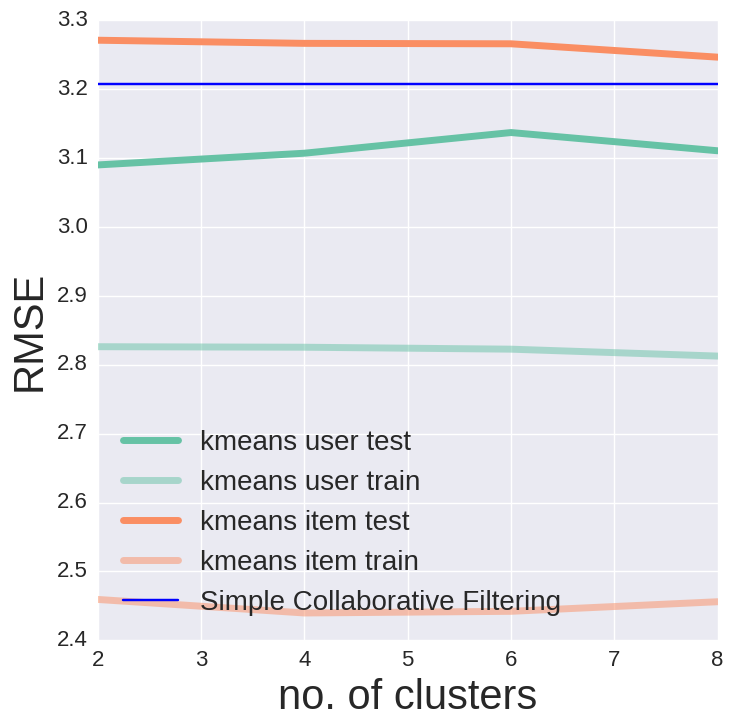

In [93]:
%matplotlib inline

sns.set()

pal = sns.color_palette("Set2", 4)

plt.figure(figsize=(8, 8))

plt.plot(k_array, kmeansuser_test, c=pal[0], label='kmeans user test', linewidth=5)
plt.plot(k_array, kmeansuser_train, c=pal[0], alpha=0.5, label='kmeans user train', linewidth=5)
plt.plot(k_array, kmeansitem_test, c=pal[1], label='kmeans item test', linewidth=5)
plt.plot(k_array, kmeansitem_train, c=pal[1],  alpha=0.5,label='kmeans item train', linewidth=5)
plt.axhline(y=user_test,label = 'Simple Collaborative Filtering')
#plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
#plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('no. of clusters', fontsize=30);
plt.ylabel('RMSE', fontsize=30);

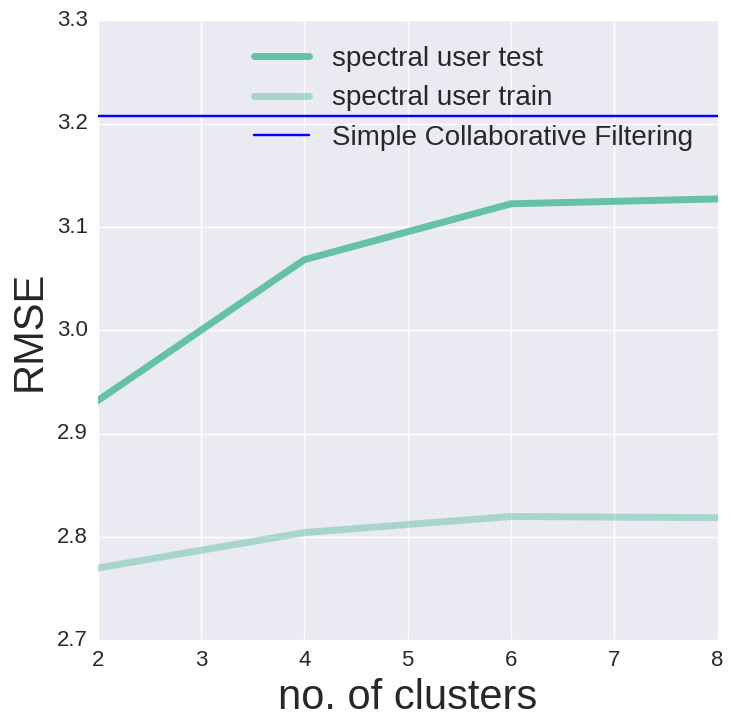

In [94]:
%matplotlib inline
sns.set()
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, spectraluser_test, c=pal[0], label='spectral user test', linewidth=5)
plt.plot(k_array, spectraluser_train, c=pal[0], alpha=0.5, label='spectral user train', linewidth=5)
plt.axhline(y=user_test,label = 'Simple Collaborative Filtering')
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('no. of clusters', fontsize=30);
plt.ylabel('RMSE', fontsize=30);

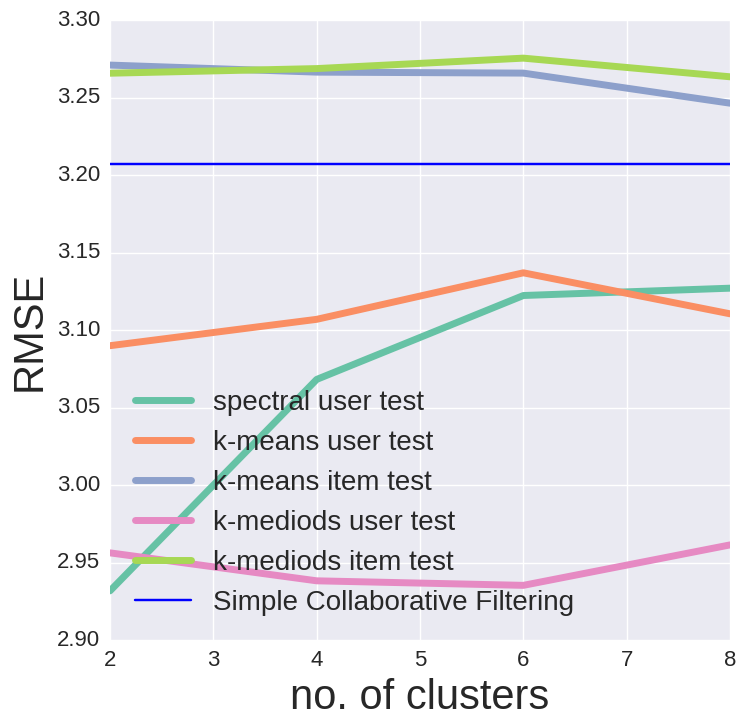

In [95]:
%matplotlib inline
sns.set()
pal = sns.color_palette("Set2", 5)
plt.figure(figsize=(8, 8))
plt.plot(k_array, spectraluser_test, c=pal[0], label='spectral user test', linewidth=5)
plt.plot(k_array, kmeansuser_test, c=pal[1], label='k-means user test', linewidth=5)
plt.plot(k_array, kmeansitem_test, c=pal[2], label='k-means item test', linewidth=5)
plt.plot(k_array, kmediodsuser_test, c=pal[3], label='k-mediods user test', linewidth=5)
plt.plot(k_array, kmediodsitem_test, c=pal[4], label='k-mediods item test', linewidth=5)
plt.axhline(y=user_test,label = 'Simple Collaborative Filtering')
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('no. of clusters', fontsize=30);
plt.ylabel('RMSE', fontsize=30);

In [96]:
def plotgraphs(pca_2d,clusterlabel,titles,i,flag):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18,7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(pca_2d) + (i + 1) * 10])
    silhouette_avg = silhouette_score(titles, clusterlabel)
    print("For n_clusters =", i,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(titles, clusterlabel)
    y_lower = 10
    for j in range(i):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[clusterlabel == j]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(j) / i)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
         # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.spectral(clusterlabel.astype(float) / i)
    ax2.scatter(pca_2d[:, 0], pca_2d[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)
     # Labeling the clusters
    
    # Draw white circles at cluster centers
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
   
    plt.suptitle(("Silhouette analysis for " + flag + " clustering on sample data "
                  "with n_clusters = %d" % i),
                 fontsize=14, fontweight='bold')
    plt.show()

('For n_clusters =', 4, 'The average silhouette_score is :', 0.47658176969508748)


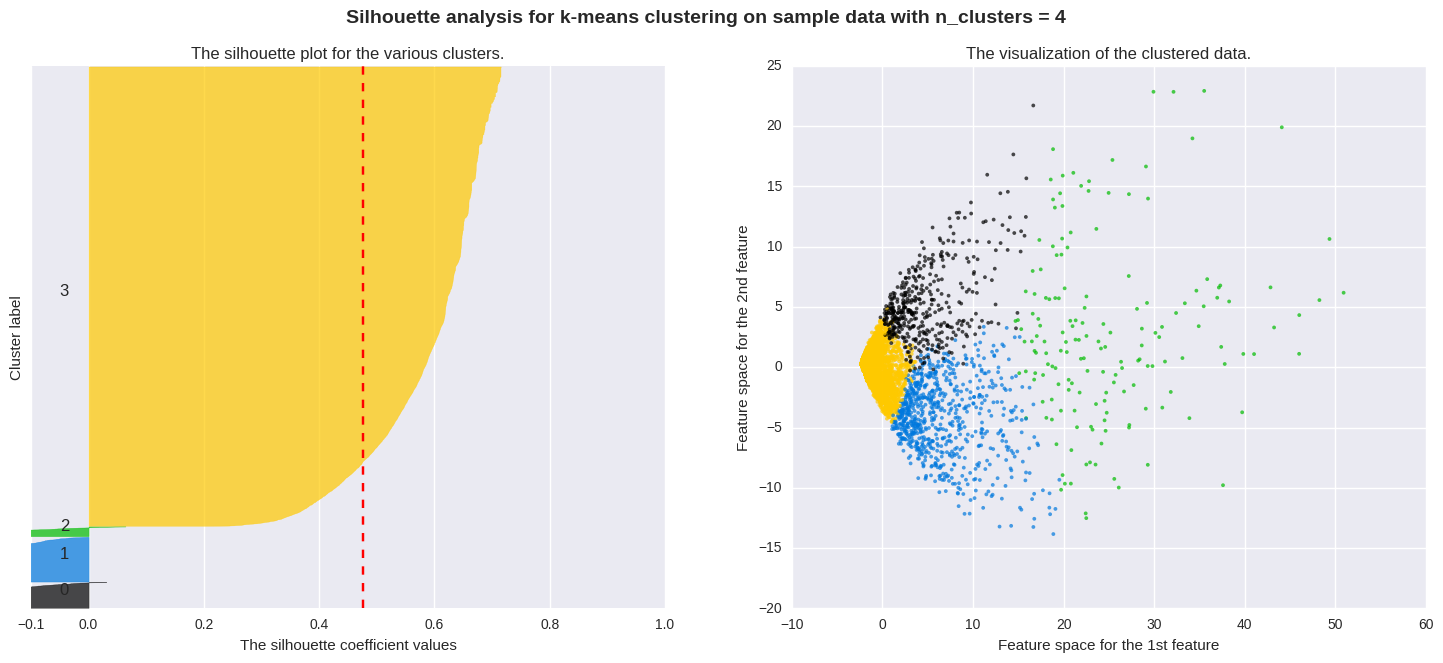

In [97]:
lablist,label = makeclusters(distance=item_distance,ratings=train_datai,flag='k-means',similarity=item_similarity1,n_cluster=4,flag1='item')
pca_2d = PCA(n_components=2).fit(train_datai).transform(train_datai)
plotgraphs(pca_2d,lablist,train_datai,4,flag='k-means')
kmeansitempred = predict_topk_nobias(train_datai, item_similarity1, label)


('For n_clusters =', 4, 'The average silhouette_score is :', -0.010504652767599763)


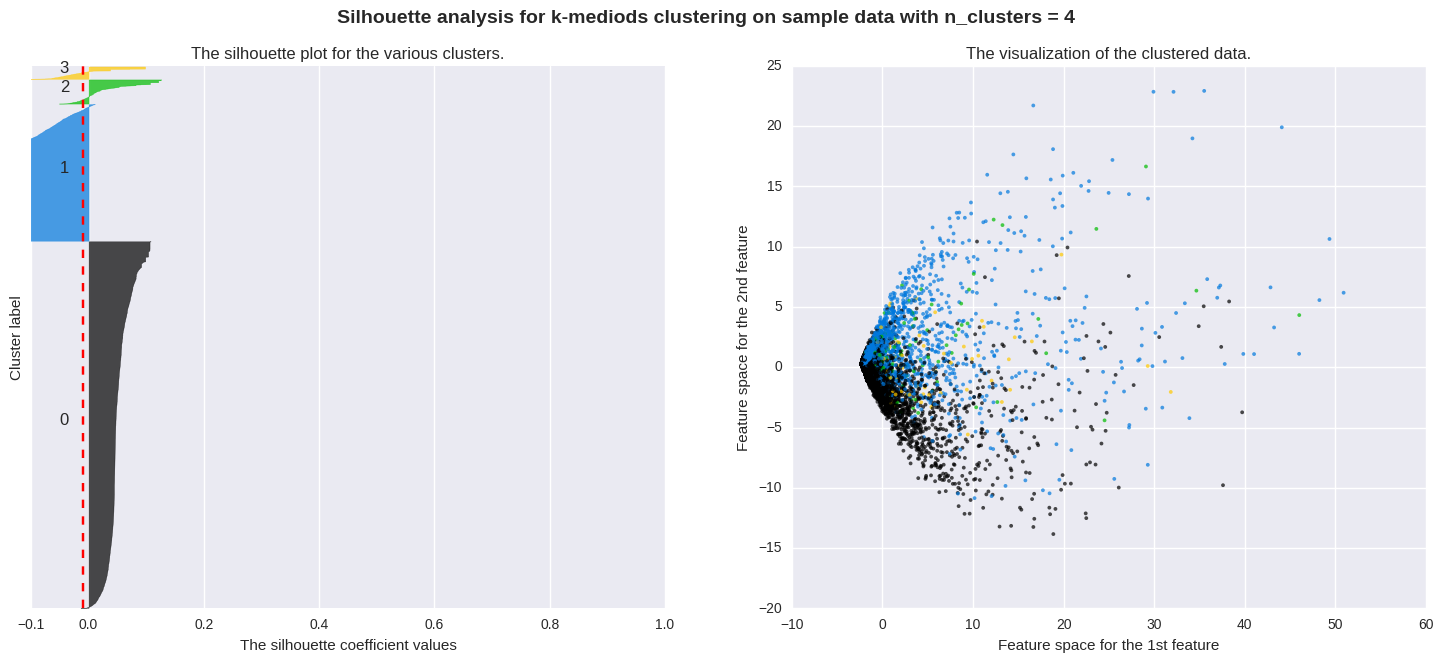

In [98]:
lablist,label = makeclusters(distance=item_distance,ratings=train_datai,flag='k-mediods',similarity=item_similarity1,n_cluster=4,flag1='item')
pca_2d = PCA(n_components=2).fit(train_datai).transform(train_datai)

plotgraphs(pca_2d,lablist,train_datai,4,flag='k-mediods')
kmediodsitempred = predict_topk_nobias(train_datai, item_similarity1, label)


('For n_clusters =', 4, 'The average silhouette_score is :', 0.3500894107545498)


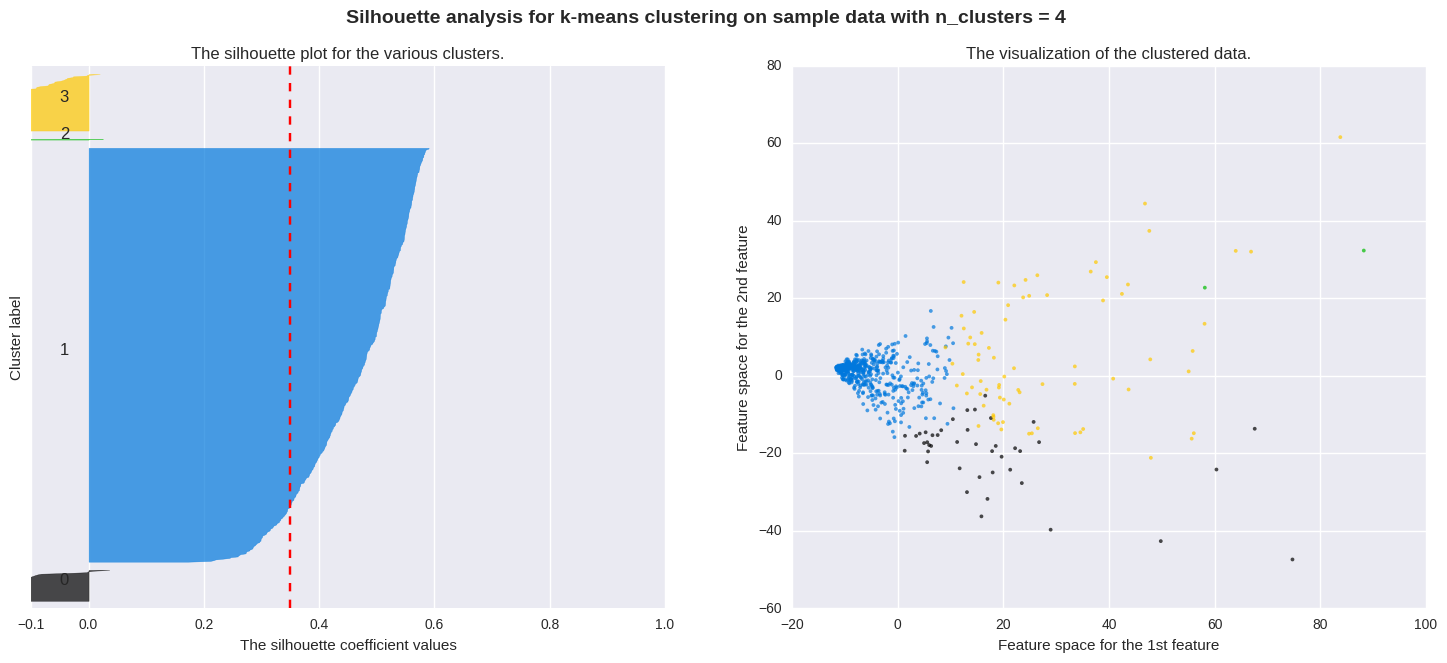

In [99]:
lablist,label = makeclusters(distance=user_distance,ratings=train_data,flag='k-means',similarity=user_similarity1,n_cluster=4)
pca_2d = PCA(n_components=2).fit(train_data).transform(train_data)
plotgraphs(pca_2d,lablist,train_data,4,flag='k-means')
kmeansuserpred = predict_topk_nobias(train_data, user_similarity1, label)


('For n_clusters =', 4, 'The average silhouette_score is :', -0.22186496804645203)


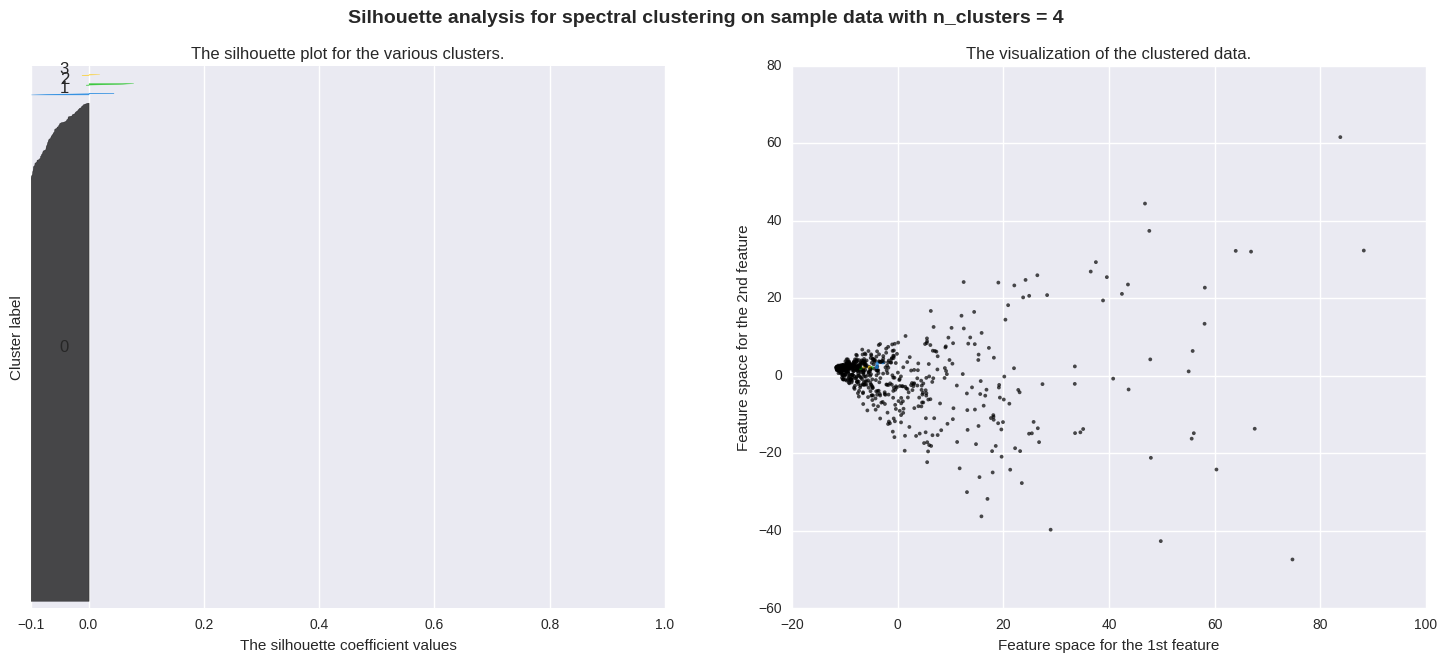

In [100]:
lablist,label = makeclusters(distance=user_distance,ratings=train_data,flag='spectral',similarity=user_similarity2,n_cluster=4)
pca_2d = PCA(n_components=2).fit(train_data).transform(train_data)
plotgraphs(pca_2d,lablist,train_data,4,flag='spectral')

spectraluserpred = predict_topk_nobias(train_data, user_similarity1, label)


('For n_clusters =', 4, 'The average silhouette_score is :', -0.10570346322175678)


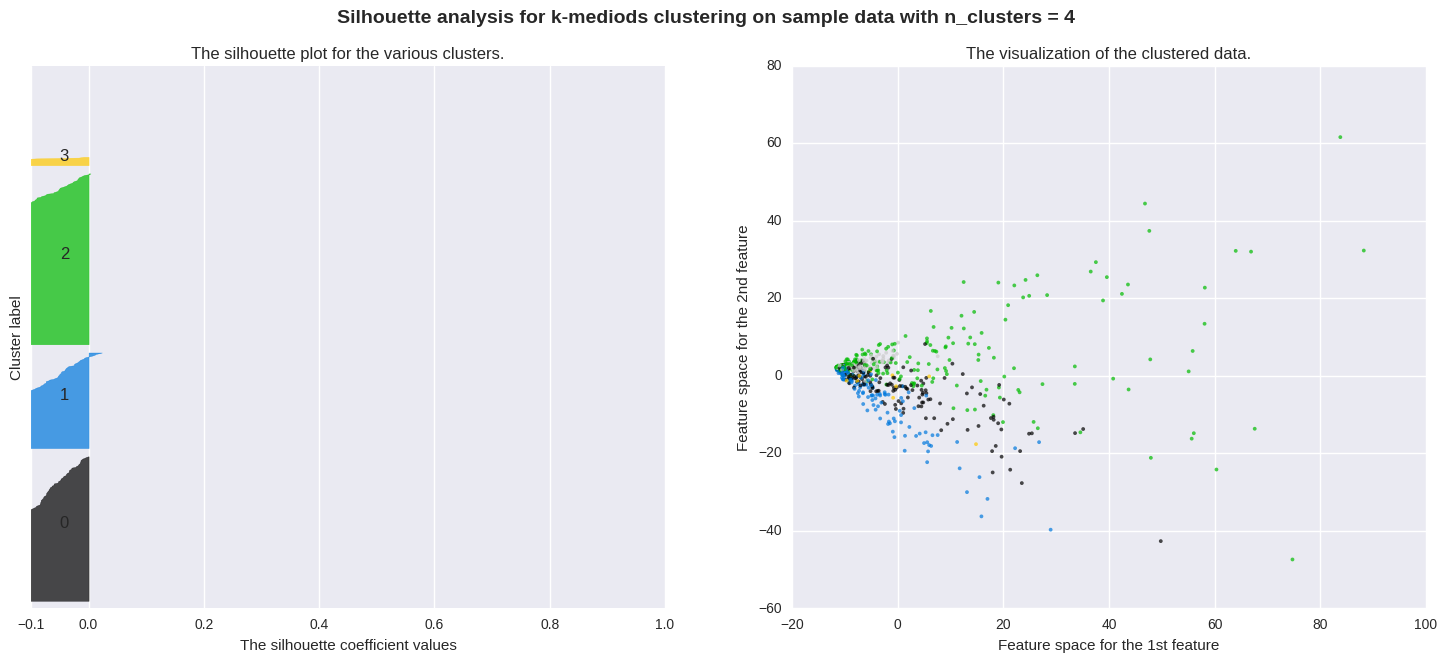

In [101]:
lablist,label = makeclusters(distance=user_distance,ratings=train_data,flag='k-mediods',similarity=user_similarity1,n_cluster=5)
pca_2d = PCA(n_components=2).fit(train_data).transform(train_data)
plotgraphs(pca_2d,lablist,train_data,4,flag='k-mediods')
kmediodsuserpred = predict_topk_nobias(train_data, user_similarity1, label)



In [114]:
userpred = predict_nobias(ratings=train_data,similarity=user_similarity1)
itempred = predict_nobias(ratings=train_datai,similarity=item_similarity1)

moviepreddf_kmeans=pd.DataFrame(kmeansuserpred)
moviepreddf_spectral=pd.DataFrame(spectraluserpred)
moviepreddf_kmediods=pd.DataFrame(kmediodsuserpred)
moviepreddf_traditional = pd.DataFrame(userpred)
moviepreddf_kmeansitem = pd.DataFrame(kmeansitempred.T)
moviepreddf_kmediodsitem = pd.DataFrame(kmediodsitempred.T)
moviepreddf_item = pd.DataFrame(itempred.T)
#pf7=pd.DataFrame(item_distance)

In [130]:
def top_k_movies(k,dataframe_index_unseen):
    for i in range(len(dataframe_index_unseen)-k,len(dataframe_index_unseen)):
         print(idx_to_movie[dataframe_index_unseen[i]])

In [132]:
def get_k_first(user_id,dataframe,k):
    dataframe_index=dataframe.iloc[user_id].index
    a=df.loc[df['user_id'] == user_id]
    b=a.item_id
    b=b.values.T.tolist()
    my_ints = [int(l) for l in b]
    my_ints1 = [int(l) for l in dataframe_index]
    ys = set(my_ints)
    dataframe_index_unseen=[item for item in my_ints1 if item not in ys]
    #print dataframe_index_unseen
    dataframe_index_unseen=[x+1 for x in dataframe_index_unseen]
    top_k_movies(k,dataframe_index_unseen)

idx_to_movie = {}
with open('./moviesnew.csv', 'r') as f:
    for line in f.readlines():
        info = line.split(',')
        try:
            id=int(info[0])
        except:
            continue
        idx_to_movie[int(info[0])] = info[2]

In [133]:
def get_movies(user_id,dataframe,k,str):   
    print "Top",k,"Recommendation by computing clusters using",str,"algorithm for user with user id",user_id,"are as follows\n"
    new_columns=(dataframe.columns[dataframe.ix[user_id].argsort()])
    dataframe=dataframe[new_columns]
    get_k_first(user_id,dataframe,k)

In [134]:
get_movies(0,moviepreddf_kmeans,10,"k-means clustering user ")
print "\n"
get_movies(0,moviepreddf_kmediods,10,"k-mediods clustering user ")
print "\n"
get_movies(0,moviepreddf_spectral,10,"spectral clustering user ")
get_movies(0,moviepreddf_traditional,10,"traditional user ")
get_movies(1,moviepreddf_item,10,"traditional item ")


Top 10 Recommendation by computing clusters using k-means clustering user  algorithm for user with user id 0 are as follows

L.A. Confidential (1997)
American Beauty (1999)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Star Wars: Episode IV - A New Hope (1977)
Schindler's List (1993)
"Silence of the Lambs
Fargo (1996)
Pulp Fiction (1994)
Dracula (Bram Stoker's Dracula) (1992)
Cinema Paradiso (Nuovo cinema Paradiso) (1989)


Top 10 Recommendation by computing clusters using k-mediods clustering user  algorithm for user with user id 0 are as follows

Goodfellas (1990)
Star Wars: Episode IV - A New Hope (1977)
Schindler's List (1993)
Amadeus (1984)
"Silence of the Lambs
"Godfather
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
One Flew Over the Cuckoo's Nest (1975)
Pulp Fiction (1994)
Fargo (1996)


Top 10 Recommendation by computing clusters using spectral clustering user  algorithm for user with user id 0 are as follows

G

In [35]:
kmeansuser_train

[2.825285629374601, 2.8214057216256117, 2.820544214261657, 2.814864338738682]

In [112]:
kmeansuserpred.shape

(671, 9125)